In [55]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Spam Call Probability - Single area code

Lets begin by looking at a dataset of spam calls. This dataset of spam calls contains a set range of Area Codes. There are 50 area codes in total; inclusively, ranging from 200-999. I want to test the hypothesis that the spam callers are more likely to call phone numbers with the area code 781 when they make their calls. Lets test this hypothesis.

Null : Spam callers are equally likely to use area codes 200-999 inclusive when they make their calls. 

Alternative : Spam callers are more likely to use the area code 781 when they make their calls. 

In [56]:
spam = Table().read_table('spam.csv')
spam

Area Code
891
924
516
512
328
613
214
781
591
950


Our Test Statistic will be using the number of times we see the area code 781 in 50 spam calls. 

We will write a function that simulates one value of our test statistic under the null hypothesis. 

In [57]:
possible_area_codes = np.arange(200,1000)
def simulate():
    stats = np.random.choice(possible_area_codes,50)
    counts = np.count_nonzero(stats==781)
    return counts
           
simulate()

0

Lets simulate 20,000 values of the number of times we see the are code 781 in 50 random spam calls. 

In [58]:
test_statistics_under_null = make_array()
repetitions = 20000
for i in np.arange(repetitions):
    simulated_values = simulate()
    test_statistics_under_null = np.append(test_statistics_under_null, simulated_values)
    
test_statistics_under_null

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

Lets look at an empirical districution of the number of times we see the area code 781 in our simulation. 

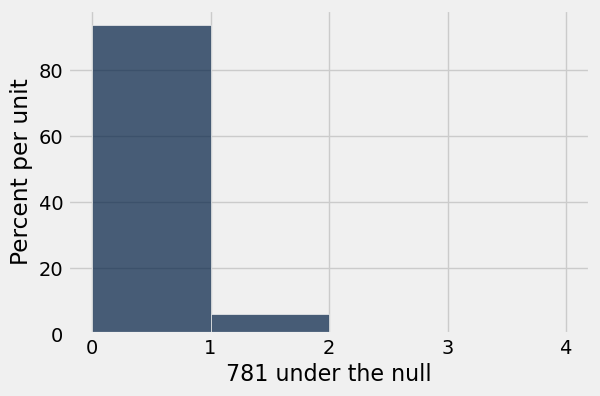

In [59]:
bins = np.arange(0,5,1) # Use these provided bins
seven_eight_one = Table().with_column('781 under the null', test_statistics_under_null)
seven_eight_one.hist(0,bins=np.arange(0,5,1))

Lets calculate a P-value to determine the significance of our test statistic.

In [60]:
observed_val = spam.where(0, are.equal_to(781)).num_rows
p_value = np.count_nonzero(test_statistics_under_null >= observed_val)/20000
p_value 

0.0018

Lets see if our simulated test statistic achieves significance. We will again use a P-Value Cut Off of 0.05 0r 5%

Because small P-Values provides us greater confidence in rejecting the null we can conclude that spam callers are in fact targeting the number 781.

# Spam Call probability - Multiple

Lets look at the probability of spam callers calling the area codes 781, 617, 509, 212, 858, 339 and 626.

We will again state our null and alternative hypothesis

Null : there is equal probability amongst all available area codes to be called by spammers.

Alternative : There is a higher probability that the spammers call the numbers 781, 617, 509, 212, 858, 339, 626

For our test statistic we will use the number of times we see any of the area codes 781, 617, 509, 212, 858, 339, 626 in 50 spam calls. 

Lets generate one simulated value of our test statistic.

In [61]:
model_proportions = make_array(.01,.99)
def simulate_specified_area_codes():
    proportions = sample_proportions(50 , model_proportions).item(0)
    return proportions * 50

simulate_specified_area_codes()

0.0

Lets generate 20,000 simulated values of the number of times we see any of the area codes 781, 617, 509, 212, 858, 339, 626 in 50 spam calls.

In [62]:
specified_test_statistics_under_null = make_array()

repetitions = 20000
for i in np.arange(repetitions):
    simulated_test_stat = simulate_specified_area_codes()
    specified_test_statistics_under_null = np.append(specified_test_statistics_under_null, simulated_test_stat)
    
specified_test_statistics_under_null

array([ 1.,  0.,  0., ...,  1.,  1.,  0.])

Lets look at the empirical distribution.

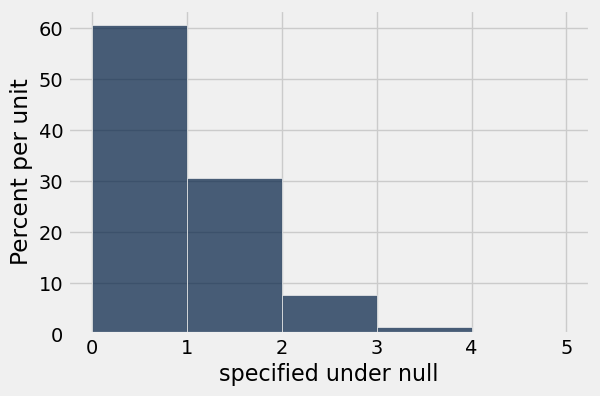

In [63]:
bins_visited = np.arange(0,6,1) # Use these provided bins
specified_under_null_table = Table().with_column('specified under null', specified_test_statistics_under_null)
specified_under_null_table.hist(0,bins=np.arange(0,6,1))

Lets again calculate our P-Value.

In [64]:
specified_area_codes = make_array(781, 617, 509, 510, 212, 858, 339, 626)
specified_observed_value = spam.where(0, are.contained_in(specified_area_codes)).num_rows
specified_observed_value
p_value = np.count_nonzero(specified_test_statistics_under_null >= specified_observed_value) / 20000
p_value

0.00165

Lets see if our simulated test statistic achieves significance. We will again use a P-Value Cut Off of 0.05 0r 5%

Because small P-Values provide us greater confidence in rejecting the null we can conclude that spam callers are in fact targeting the numbers 781, 617, 509, 212, 858, 339, 626. 

# A/B Testing

The following table is a sampled table that contains two columns. The first column indicates if a given value is one of our selected numbers, 781, 617, 509, 212, 858, 339, 626. The second column indicates whether or not the spam call was answered. 

In [65]:
with_labels = Table().read_table("spam_picked_up.csv")
Specified_Area_codes = with_labels.relabeled("Area Code Visited", "Specified Area Codes")
Specified_Area_codes

Specified Area Codes,Picked Up
No,0
No,1
No,1
Yes,0
No,0
No,0
Yes,0
No,1
No,1
No,1


Lets set up an A/B test to determine if we are more likely to pick up a call from one of our specified area codes. (781, 617, 509, 212, 858, 339, 626). Lets again set up our null and alternative hypothesis.

Null : There is no difference in the distribution of calls between our specified area codes (marked as yes in our first column) and and non selected area codes (marked as no in our first column) with any difference due to chance.

Alternative : There is a difference between the two categories and that we are more likely to pick up the specified area codes.

# Permutation test

Test Statistic : Difference in proportion of calls picked up between the area codes 781, 617, 509, 212, 858, 339, 626 and the all other codes. 

In [66]:
Specified_Area_codes.group('Specified Area Codes', np.mean)

Specified Area Codes,Picked Up mean
No,0.514286
Yes,0.733333


Lets make a function to calculate our test statistic.

In [70]:
def difference_in_proportion(sample):
    proportions = sample.group('Specified Area Codes',np.mean)
    proportion_visited = proportions.where("Specified Area Codes", "Yes").column("Picked Up mean").item(0)
    proportion_not_visited = proportions.where("Specified Area Codes", "No").column("Picked Up mean").item(0)
    return proportion_visited - proportion_not_visited

observed_diff_proportion = difference_in_proportion(Specified_Area_codes)
observed_diff_proportion

0.21904761904761905

To perform a permutation test we shuffle the labels, because our null hypothesis is that the labels don't matter because the distribution of calls between specified and non specified area codes come from the same underlying distribution. The labels in this case is the "Specified area codes" column containing "Yes" and "No".

In [73]:
def simulate_one_stat():
    shuffled = Specified_Area_codes.sample(with_replacement=False)
    original_with_shuffled_labels = with_labels.with_columns('Specified Area Codes',shuffled.column('Specified Area Codes'))
    return difference_in_proportion(original_with_shuffled_labels)

one_simulated_test_stat = simulate_one_stat() 
one_simulated_test_stat

0.02857142857142858

Lets generate 1000 simulated test statistic values and look at a histogram.

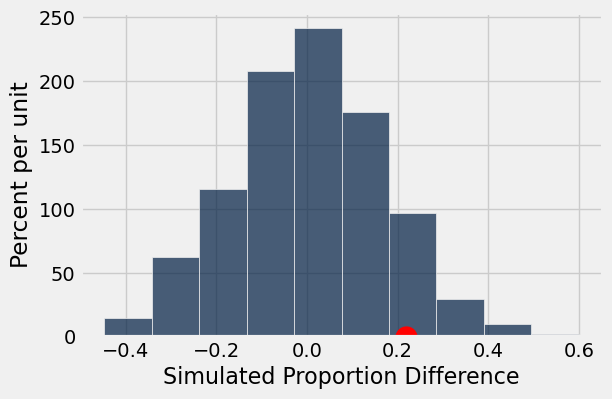

In [75]:
trials = 1000
test_stats = make_array()
for i in np.arange(trials):
    sims = simulate_one_stat()
    test_stats = np.append(test_stats, sims)

Table().with_column("Simulated Proportion Difference", test_stats).hist("Simulated Proportion Difference");
plt.plot(observed_diff_proportion, 0, 'ro', markersize=15);

Lets now look at our empirical P-Value.

In [76]:
p_value_ab = np.count_nonzero(test_stats >= observed_diff_proportion) / 1000
p_value_ab

0.144

With a 0.05 or 5% P-Value Cut off we can reject the alternative in favor of the null that there is no difference in the distribution of spam calls and that what little there is is due to chance.